# 🌍 GeoViT: A Convolutional-Transformer Model for Geolocation Prediction

Welcome to the GeoViT project notebook!

This notebook presents the training, evaluation, and experimentation pipeline for **GeoViT**, a neural network model designed to **predict geographic locations from Google Street View images**. The model takes inspiration from the popular game *Geoguessr* and is trained using a subset of the [OpenStreetView-5M dataset](https://huggingface.co/datasets/osv5m/osv5m).

🖊️ Authors: Alan Tran and Caleb Wolf

---

## 📌 Project Goals

1. **Train** a hybrid convolutional-transformer model that can learn geospatial patterns from street-level imagery.
2. **Evaluate** the model's accuracy depends on predicting the correct S2 grid cell (based on Google S2 Geometry).
3. **Experiment** with:
   - Ablations
   - Probability Distribution on a map for visualization

---

## 🧠 Model Overview

- **Convolutional Frontend:** Captures local texture and object-level features.
- **Vision Transformer (ViT):** Captures global spatial dependencies.
- **Output:** Grid classes based on the Google S2 geometry

---

## 🧪 Experiments

### ✅ Experiment 1: ViT Ablation
- Test ablations to see what features the model finds important

### ✅ Experiment 2: Robustness to Cropped Context
- Visualize the model's porbability distribution on the map
- A good model would cluster around the correct class whereas a bad model would have scattered predictions

---

## Hybrid CNN-ViT Model Training

In [ ]:
import os
import glob
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
import torchvision.models as models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm
import timm
import heapq
import csv
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Polygon as ShapelyPolygon
from matplotlib.cm import ScalarMappable
from s2sphere import LatLng, Cell, CellId
import random
from mpl_toolkits.axes_grid1 import make_axes_locatable

c:\Users\alan\anaconda3\envs\NN1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# define cell partition algorithm

# Class that maps cells to grid indices
class Region:
    __slots__ = ('cell_id','level','indices')
    def __init__(self, cell_id, level, indices):
        self.cell_id = cell_id     
        self.level   = level       
        self.indices = indices     
    def count(self): 
        return len(self.indices)
    def split(self, df, lat_col, lon_col):
        """Split into children at level+1 and group membership."""
        next_level = self.level + 1
        groups = {}
        for i in self.indices:
            lat, lon = df.at[i, lat_col], df.at[i, lon_col]
            cid = CellId.from_lat_lng(LatLng.from_degrees(lat, lon)) \
                         .parent(next_level)
            groups.setdefault(cid.id(), []).append(i)
        return [
            Region(CellId(child_id), next_level, idxs)
            for child_id, idxs in groups.items()
        ]

def build_planet_partitions(
    train_df: pd.DataFrame,
    lat_col: str = 'latitude',
    lon_col: str = 'longitude',
    t1: int = 10000,
    t2: int = 50
):
    """
    Performs PlaNet‐style adaptive partitioning on train_df,
    returns (labels, kept_regions):
      - labels: pd.Series of length train_df, with class 0…K-1 (or -1)
      - kept_regions: list of Region objects whose cells were kept (count >= t2)
    """
    # 1) Seed with level=0 roots
    root_ids = train_df.apply(
        lambda r: CellId
            .from_lat_lng(LatLng.from_degrees(r[lat_col], r[lon_col]))
            .parent(0)
            .id(),
        axis=1
    )
    roots = [
        Region(CellId(rid), 0, idxs.tolist())
        for rid, idxs in root_ids.groupby(root_ids).groups.items()
    ]

    # 2) Recursively split any region > t1
    heap = [(-r.count(),  r.cell_id.id(),  r) for r in roots]
    heapq.heapify(heap)

    leaves = []
    while heap:
        negc, _, region = heapq.heappop(heap)
        if region.count() > t1:
            for child in region.split(train_df, lat_col, lon_col):
                # push with the same tuple structure
                heapq.heappush(heap, (-child.count(), child.cell_id.id(), child))
        else:
            leaves.append(region)

    # 3) Prune leaves < t2
    kept = [r for r in leaves if r.count() >= t2]

    # 4) Assign train labels
    train_labels = pd.Series(-1, index=train_df.index, dtype=int)
    for cls_idx, region in enumerate(kept):
        train_labels.loc[region.indices] = cls_idx

    return train_labels, kept

def assign_planet_labels(
    df: pd.DataFrame,
    regions: list,
    lat_col: str = 'latitude',
    lon_col: str = 'longitude',
) -> pd.Series:
    
    by_level = {}
    for cls_idx, reg in enumerate(regions):
        by_level.setdefault(reg.level, {})[reg.cell_id.id()] = cls_idx

    labels = pd.Series(-1, index=df.index, dtype=int)

    # For each unique level, compute all cell_ids in bulk and map
    for level, mapping in by_level.items():
        # compute cell_id.id() at this level for every point
        ids = df.apply(
            lambda r: CellId
                .from_lat_lng(LatLng.from_degrees(r[lat_col], r[lon_col]))
                .parent(level)
                .id(),
            axis=1
        )
        # map to class_idx (NaN becomes -1)
        mapped = ids.map(mapping).fillna(-1).astype(int)
        # only overwrite labels that are still -1
        mask = (labels == -1) & (mapped >= 0)
        labels.loc[mask] = mapped.loc[mask]

    return labels


In [ ]:
# load data and initialize partitions

DATA_ROOT = 'osv5m/'
TRAIN_CSV = os.path.join(DATA_ROOT, 'train_mini.csv')
TEST_CSV = os.path.join(DATA_ROOT, 'test_mini.csv')
TRAIN_IMG_DIR = os.path.join(DATA_ROOT, 'train_images')
TEST_IMG_DIR = os.path.join(DATA_ROOT, 'test_images')

EPOCHS = 25
BATCH_SIZE = 32
L = 10
LABEL_COL = 'planet_class'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

train_labels, kept_regions = build_planet_partitions(
    train_df, lat_col='latitude', lon_col='longitude',
    t1=100, t2=20
)
train_df[LABEL_COL] = train_labels
train_df = train_df[train_labels >= 0].reset_index(drop=True)

test_labels = assign_planet_labels(
    test_df, kept_regions, lat_col='latitude', lon_col='longitude'
)
test_df[LABEL_COL] = test_labels
test_df = test_df[test_labels >= 0].reset_index(drop=True)

In [4]:
print(train_df[LABEL_COL].unique()[:5])
print(train_df[LABEL_COL].nunique())

[ 88 668 884 311 985]
2199


In [ ]:
# Define CNN + ViT hybrid model and dataset class

class CNN_ViT_Hybrid(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.cnn = timm.create_model("resnet50", pretrained=True, features_only=True)
        cnn_out_channels = self.cnn.feature_info[-1]['num_chs']

        self.vit = timm.create_model("vit_small_patch16_224", pretrained=True)
        self.vit.head = nn.Identity()  # remove classifier

        self.pool = nn.AdaptiveAvgPool2d((14, 14))
        self.proj = nn.Linear(cnn_out_channels, self.vit.embed_dim)

        self.dropout = nn.Dropout(p=0.2) # Dropout Regularization
        self.classifier = nn.Linear(self.vit.embed_dim, num_classes)

    def forward(self, x):
        x = self.cnn(x)[-1] 
        x = self.pool(x)
        x = x.flatten(2).transpose(1, 2)
        x = self.proj(x)
        x = self.vit.blocks(x)
        x = x.mean(dim=1)  # Global average pooling
        x = self.dropout(x)

        return self.classifier(x)
    
# Define the geospatial dataset class
class GeoDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        images_root: str,
        nclasses: int,
        label_col: str = 'planet_class',
        transforms=None
    ):
        self.df = df[df[label_col] >= 0].reset_index(drop=True)

        self.label_col = label_col
        self.classes = nclasses

        all_files = glob.glob(os.path.join(images_root, '*', '*.jpg'))
        self.id2path = {
            os.path.splitext(os.path.basename(p))[0]: p
            for p in all_files
        }

        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row    = self.df.iloc[idx]
        img_id = str(row['id'])
        label  = int(row[self.label_col])
        img    = Image.open(self.id2path[img_id]).convert('RGB')
        if self.transforms:
            img = self.transforms(img)
        return img, label

In [ ]:
# define transforms, initialize datasets, dataloaders, model, and optimizer

train_transforms = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# no augmentation for test set
# (but still normalize to same size as training set)
test_transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Instantiate the dataset and dataloaders
train_ds = GeoDataset(
    df          = train_df,
    images_root = TRAIN_IMG_DIR,
    label_col   = LABEL_COL,
    nclasses    = len(kept_regions),
    transforms  = train_transforms
)

test_ds = GeoDataset(
    df          = test_df,
    images_root = TEST_IMG_DIR,
    label_col   = LABEL_COL,
    nclasses    = len(kept_regions),
    transforms  = test_transforms
)

print(f"Softmax size (num classes) = {train_ds.classes}")

num_val = int(0.1 * len(train_ds)) # 90% training set, 10% testing set
num_train = len(train_ds) - num_val
train_subset, val_subset = random_split(train_ds, [num_train, num_val], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_subset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,      batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = CNN_ViT_Hybrid(num_classes=train_ds.classes).to(device)
criterion = nn.CrossEntropyLoss()

for param in model.cnn.parameters():
    param.requires_grad = False

for param in model.vit.parameters():
    param.requires_grad = False

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=1e-4, 
    weight_decay=1e-4
)

# Reduce learning rate when validation loss plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2,  
    verbose=True
)

Softmax size (num classes) = 2199


c:\Users\alan\anaconda3\envs\NN1\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
# get dimensions
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break

torch.Size([32, 3, 224, 224]) torch.Size([32])


In [ ]:
# Training and evaluation functions

def train_one_epoch(model, loader):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for images, labels in tqdm(loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        correct += outputs.argmax(1).eq(labels).sum().item()
        total += labels.size(0)
    return running_loss / total, correct / total

def evaluate1(model, loader):
    model.eval()
    running_loss, correct, total = 0, 0, 0
    correct_pred_idx = []
    current_index = 0  # global index tracker

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

            for i in range(len(preds)):
                if preds[i] == labels[i]:
                    correct_pred_idx.append(current_index + i)

            current_index += len(preds)

    return running_loss / total, correct / total, correct_pred_idx

def evaluate2(model, loader):
    model.eval()
    running_loss, correct_top1, correct_top3, correct_top5, total = 0, 0, 0, 0, 0
    correct_pred_idx = []
    current_index = 0  # global index tracker

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            total += labels.size(0)

            # Get top-k predictions
            _, pred_top5 = outputs.topk(5, dim=1)  # top-5 predictions (shape: batch_size x 5)

            # Top-1 Accuracy
            correct_top1 += pred_top5[:, 0].eq(labels).sum().item()

            # Top-3 Accuracy
            correct_top3 += sum([labels[i] in pred_top5[i, :3] for i in range(labels.size(0))])

            # Top-5 Accuracy
            correct_top5 += sum([labels[i] in pred_top5[i, :] for i in range(labels.size(0))])

            # Track correct indices for experiments
            preds = outputs.argmax(1)
            for i in range(len(preds)):
                if preds[i] == labels[i]:
                    correct_pred_idx.append(current_index + i)

            current_index += len(preds)

    loss_avg = running_loss / total
    acc_top1 = correct_top1 / total
    acc_top3 = correct_top3 / total
    acc_top5 = correct_top5 / total

    return loss_avg, acc_top1, acc_top3, acc_top5, correct_pred_idx


In [ ]:
# train model and save/log progress

log_file = open("training_log.csv", mode="a", newline="")
logger = csv.writer(log_file)
logger.writerow(["epoch", "train_loss", "train_acc", "val_loss", "val_acc", "lr"])

writer = SummaryWriter("runs/geo_model_experiment")

model.load_state_dict(torch.load("hybrid_best_model_epoch20.pth"))
model.to(device)

best_val_acc = 0.3438
best_val_loss = 3.1068
# Training Loop
for epoch in range(EPOCHS):
    print(f"\n🌍 Epoch {epoch+1}/{EPOCHS}")

    if epoch == 3:
        print("🔓 Unfreezing layers...")
        for param in model.cnn.parameters():
            param.requires_grad = True
        for param in model.vit.parameters():
            param.requires_grad = True
        optimizer = optim.Adam(
            filter(lambda p: p.requires_grad, model.parameters()), 
            lr=1e-5,
            weight_decay=1e-4
        )

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=2,
            verbose=True
        )

    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc, ignore     = evaluate1(model, val_loader)

    scheduler.step(val_loss)
    for param_group in optimizer.param_groups:
        print(f"Current learning rate: {param_group['lr']}")

    current_lr = optimizer.param_groups[0]['lr']
    logger.writerow([epoch+1, train_loss, train_acc, val_loss, val_acc, current_lr])
    log_file.flush()

    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Loss/val", val_loss, epoch)
    writer.add_scalar("Accuracy/train", train_acc, epoch)
    writer.add_scalar("Accuracy/val", val_acc, epoch)

    for param_group in optimizer.param_groups:
        writer.add_scalar("Learning Rate", param_group['lr'], epoch)



    print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    if val_loss < best_val_loss or val_acc > best_val_acc:
        best_val_loss = val_loss
        best_val_acc = val_acc
        torch.save(model.state_dict(), f"hybrid_best_model_epoch{epoch+1}.pth")
        print("✅ Saved best model.")

log_file.close()
writer.close()

🌍 Epoch 6/10
100%|██████████| 3166/3166 [26:56<00:00,  1.96it/s]
Current learning rate: 0.0001
Train Loss: 5.1646, Acc: 0.1002
Val   Loss: 4.6061, Acc: 0.1496
✅ Saved best model.

🌍 Epoch 7/10
100%|██████████| 3166/3166 [21:32<00:00,  2.45it/s]
Current learning rate: 0.0001
Train Loss: 4.5202, Acc: 0.1492
Val   Loss: 4.2192, Acc: 0.1907
✅ Saved best model.

🌍 Epoch 9/10
100%|██████████| 3166/3166 [17:45<00:00,  2.97it/s]
Current learning rate: 0.0001
Train Loss: 3.9185, Acc: 0.2158
Val   Loss: 3.8253, Acc: 0.2363
✅ Saved best model.

🌍 Epoch 10/10
100%|██████████| 3166/3166 [17:44<00:00,  2.97it/s]
Current learning rate: 0.0001
Train Loss: 3.7284, Acc: 0.2397
Val   Loss: 3.7004, Acc: 0.2514
✅ Saved best model.

🌍 Epoch 11/15
100%|██████████| 3166/3166 [18:15<00:00,  2.89it/s]
Current learning rate: 0.0001
Train Loss: 3.5743, Acc: 0.2618
Val   Loss: 3.5668, Acc: 0.2738
✅ Saved best model.

🌍 Epoch 12/15
100%|██████████| 3166/3166 [18:06<00:00,  2.91it/s]
Current learning rate: 0.0001
Train Loss: 3.4266, Acc: 0.2819
Val   Loss: 3.4764, Acc: 0.2845
✅ Saved best model.

🌍 Epoch 13/15
100%|██████████| 3166/3166 [22:35<00:00,  2.34it/s]
Current learning rate: 0.0001
Train Loss: 3.3198, Acc: 0.2963
Val   Loss: 3.4377, Acc: 0.2873
✅ Saved best model.

🌍 Epoch 14/15
100%|██████████| 3166/3166 [26:04<00:00,  2.02it/s]
Current learning rate: 0.0001
Train Loss: 3.2206, Acc: 0.3098
Val   Loss: 3.3822, Acc: 0.2968
✅ Saved best model.

🌍 Epoch 15/15
100%|██████████| 3166/3166 [24:24<00:00,  2.16it/s]
Current learning rate: 0.0001
Train Loss: 3.1338, Acc: 0.3242
Val   Loss: 3.3237, Acc: 0.3075
✅ Saved best model.

🌍 Epoch 16/20
100%|██████████| 1583/1583 [20:24<00:00,  1.22it/s]
Current learning rate: 0.0001
Train Loss: 2.9151, Acc: 0.3659
Val   Loss: 3.2312, Acc: 0.3250
✅ Saved best model.

🌍 Epoch 17/20
100%|██████████| 1583/1583 [22:27<00:00,  1.17it/s]
Current learning rate: 0.0001
Train Loss: 2.8023, Acc: 0.3822
Val   Loss: 3.1983, Acc: 0.3266
✅ Saved best model.

🌍 Epoch 18/20
100%|██████████| 1583/1583 [17:51<00:00,  1.48it/s]
Current learning rate: 0.0001
Train Loss: 2.7328, Acc: 0.3943
Val   Loss: 3.1607, Acc: 0.3410
✅ Saved best model.

🌍 Epoch 19/20
100%|██████████| 1583/1583 [20:45<00:00,  1.27it/s]
Current learning rate: 0.0001
Train Loss: 2.6605, Acc: 0.4051
Val   Loss: 3.1057, Acc: 0.3437
✅ Saved best model.

🌍 Epoch 20/20
100%|██████████| 1583/1583 [22:33<00:00,  1.17it/s]
Current learning rate: 0.0001
Train Loss: 2.6142, Acc: 0.4102
Val   Loss: 3.1068, Acc: 0.3438
✅ Saved best model.

In [ ]:
# Final Test
model.load_state_dict(torch.load('hybrid_best_model_epoch23.pth'))
model.to(device)
test_loss,test_acc1, test_acc3, test_acc5, correct_indices = evaluate2(model, test_loader)
print(f"\n✅ Final Test Loss: {test_loss:.4f}")
print(f"Top-1 Accuracy: {test_acc1:.4f}")
print(f"Top-3 Accuracy: {test_acc3:.4f}")
print(f"Top-5 Accuracy: {test_acc5:.4f}")

C:\Users\alan\AppData\Local\Temp\ipykernel_2288\4073866379.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('hybrid_best_model_epoch23.pt


✅ Final Test Loss: 6.0729
Top-1 Accuracy: 0.1536
Top-3 Accuracy: 0.2655
Top-5 Accuracy: 0.3176


In [ ]:
# Finetuning further by freezing the CNN layers
# Load the best model
model.load_state_dict(torch.load('hybrid_best_model_epoch23.pth'))
model.to(device)

for param in model.cnn.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True


# Only params that require gradients
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(trainable_params, lr=1e-5)

fine_tune_epochs = 3
start_epoch = 25
best_val_loss = float('inf')
best_val_acc = 0.0

for epoch in range(start_epoch, start_epoch + fine_tune_epochs):
    print(f"\n🎯 Fine-tuning Epoch {epoch+1}/{start_epoch + fine_tune_epochs}")
    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc, correct_indices     = evaluate1(model, val_loader)

    print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    if val_loss < best_val_loss or val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), f"hybrid_best_model_epoch{epoch+1}.pth")
        print("✅ Saved best model.")


🎯 Fine-tuning Epoch 24/26


C:\Users\alan\AppData\Local\Temp\ipykernel_1988\625372891.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('hybrid_best_model_epoch23.pth

KeyboardInterrupt: 

🎯 Fine-tuning Epoch 21/22
100%|██████████| 1583/1583 [22:03<00:00,  1.20it/s]
Train Loss: 2.4489, Acc: 0.4439
Val   Loss: 3.0341, Acc: 0.3596
✅ Saved best model.

🎯 Fine-tuning Epoch 22/22
100%|██████████| 1583/1583 [20:58<00:00,  1.26it/s]
Train Loss: 2.4089, Acc: 0.4543
Val   Loss: 3.0418, Acc: 0.3574
✅ Saved best model.

🎯 Fine-tuning Epoch 23/22
100%|██████████| 1583/1583 [20:20<00:00,  1.30it/s]
Train Loss: 2.3900, Acc: 0.4564
Val   Loss: 2.9985, Acc: 0.3601
✅ Saved best model.

After training, go to the terminal bash and run: tensorboard --logdir=runs
in order to see visualizations. Then go to http://localhost:6006

In [ ]:
# Final Test
test_loss, test_acc, correct_indices = evaluate(model, test_loader)
print(f"\n✅ Final Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")


✅ Final Test Loss: 5.9503, Accuracy: 0.1639


## Experiment 1: Ablations and Heat Map

C:\Users\alan\AppData\Local\Temp\ipykernel_2288\1655665205.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("hybrid_best_model_epoch20.p

1119 correct predictions, choosing sample 4179 out of 7287


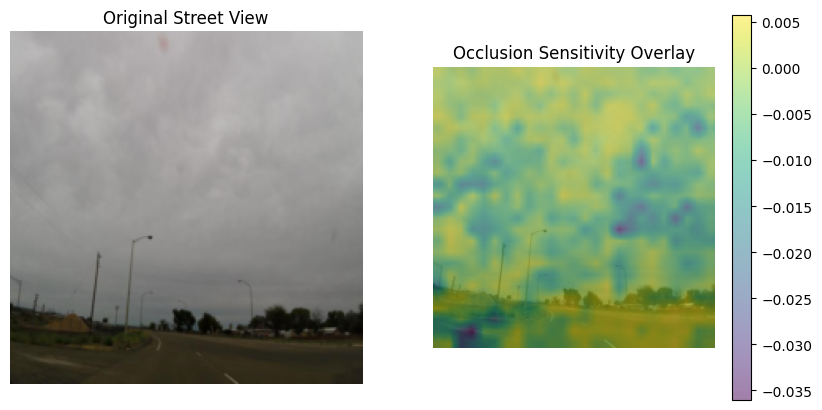

In [ ]:
# Visualize the model's predictions on a map

def compute_occlusion_map(
    model,
    image,            
    label,            
    patch_size=32,
    stride=16,
    occlusion_value=0
):
    model.eval()
    device = next(model.parameters()).device
    image = image.to(device)
    with torch.no_grad():
        out = model(image.unsqueeze(0))
        p0  = F.softmax(out, dim=1)[0, label].item()

    _, H, W  = image.shape
    n_rows   = (H - patch_size)//stride + 1
    n_cols   = (W - patch_size)//stride + 1
    heatmap  = torch.zeros((n_rows, n_cols), device=device)

    for i in range(n_rows):
        for j in range(n_cols):
            top, left = i*stride, j*stride
            occ = image.clone()
            occ[:, top:top+patch_size, left:left+patch_size] = occlusion_value
            with torch.no_grad():
                out_ij = model(occ.unsqueeze(0))
                prob   = F.softmax(out_ij, dim=1)[0, label].item()
            heatmap[i, j] = p0 - prob

    heatmap = heatmap.unsqueeze(0).unsqueeze(0)
    heatmap = F.interpolate(heatmap, size=(H, W), mode='bilinear', align_corners=False)
    return heatmap.squeeze().cpu().numpy()


model.load_state_dict(torch.load("hybrid_best_model_epoch20.pth"))
model.to(device)

idx = random.choice(correct_indices)
# idx = 2201 
# 5633
# 6512
#4179
print(f"{len(correct_indices)} correct predictions, choosing sample {idx} out of {len(test_ds)}")
img, label = train_ds[idx]


# Unnormalize for display
mean = torch.tensor([.485, .456, .406]).view(3,1,1)
std  = torch.tensor([.229, .224, .225]).view(3,1,1)
img_disp = img * std + mean
img_np   = np.transpose(img_disp.numpy(), (1,2,0))

heatmap = compute_occlusion_map(model, img, label, patch_size=32, stride=8, occlusion_value=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.imshow(img_np)
ax1.axis('off')
ax1.set_title('Original Street View')

# Overlay heatmap on the original image
ax2.imshow(img_np) 
im = ax2.imshow(heatmap, cmap='viridis', alpha=0.5)
ax2.axis('off')
ax2.set_title('Occlusion Sensitivity Overlay')

fig.colorbar(im, ax=ax2)



C:\Users\alan\AppData\Local\Temp\ipykernel_8052\4241375589.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("hybrid_best_model_epoch23.pt

1194 correct predictions, choosing sample 2201 out of 7287


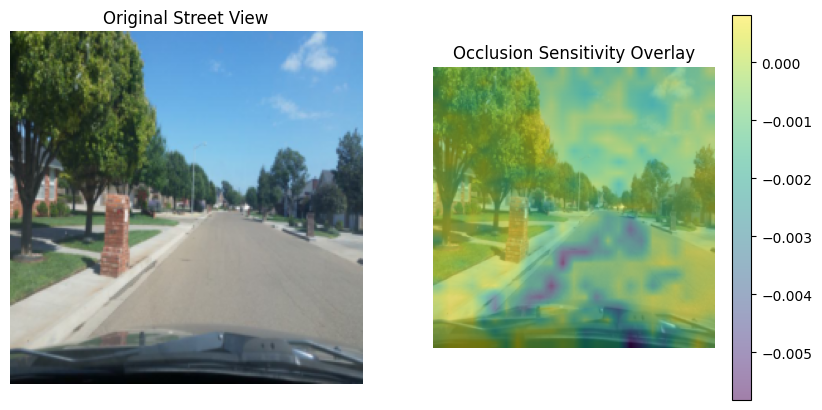

In [ ]:
model.load_state_dict(torch.load("hybrid_best_model_epoch23.pth"))
model.to(device)

# idx = random.choice(correct_indices)
idx = 2201 
print(f"{len(correct_indices)} correct predictions, choosing sample {idx} out of {len(test_ds)}")
img, label = train_ds[idx]


# Unnormalize for display
mean = torch.tensor([.485, .456, .406]).view(3,1,1)
std  = torch.tensor([.229, .224, .225]).view(3,1,1)
img_disp = img * std + mean
img_np   = np.transpose(img_disp.numpy(), (1,2,0))

heatmap = compute_occlusion_map(model, img, label, patch_size=32, stride=8, occlusion_value=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.imshow(img_np)
ax1.axis('off')
ax1.set_title('Original Street View')

# Overlay heatmap on the original image
ax2.imshow(img_np) 
im = ax2.imshow(heatmap, cmap='viridis', alpha=0.5)
ax2.axis('off')
ax2.set_title('Occlusion Sensitivity Overlay')

fig.colorbar(im, ax=ax2)



## Experiment 2: Model Probability Distribution on US Map

In [ ]:

idx = random.randrange(len(test_df))
sample_id = str(test_df['id'].iloc[idx])
print(f"Selected sample index {idx}, image ID = {sample_id}")

img_path     = test_ds.id2path[sample_id]
img          = Image.open(img_path).convert('RGB')
inp          = test_transforms(img).unsqueeze(0).to(device)
with torch.no_grad():
    logits = model(inp)
    probs  = torch.softmax(logits, dim=1)[0].cpu().numpy()

# Extract the ground‐truth lat/lon for this sample
row = test_df[test_df['id'] == int(sample_id)].iloc[0]
true_lat, true_lon = row['latitude'], row['longitude']

fig = plt.figure(figsize=(12,8))
ax  = plt.axes(projection=ccrs.LambertConformal())
ax.set_extent([-125, -66.5, 24, 50], crs=ccrs.PlateCarree())
ax.coastlines('50m')
ax.add_feature(cfeature.STATES)

sm = ScalarMappable(cmap='viridis', norm=plt.Normalize(0, probs.max()))
for idx, region in enumerate(kept_regions):
    s2cell = Cell(region.cell_id)
    coords = []
    for corner in range(4):
        pt = s2cell.get_vertex(corner)
        ll = LatLng.from_point(pt)
        coords.append((ll.lng().degrees, ll.lat().degrees))
    coords.append(coords[0])
    poly = ShapelyPolygon(coords)
    ax.add_geometries(
        [poly], crs=ccrs.PlateCarree(),
        facecolor=sm.to_rgba(probs[idx]),
        edgecolor='none', alpha=0.8, zorder=2
    )

ax.plot(true_lon, true_lat, 'o', color='red', markersize=8,
        transform=ccrs.PlateCarree(), zorder=3)

divider = make_axes_locatable(ax)
cax     = divider.append_axes(
    "right", size="3%", pad=0.05,
    axes_class=plt.Axes  
)

sm.set_array(probs)
cbar = fig.colorbar(sm, cax=cax, label='P(class)')

ax.set_title(f'Probability Map for Image {sample_id}')
plt.show()